In [1]:
## Imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
## Constants
dir = '../input/tabular-playground-series-may-2021'

In [3]:
train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv', index_col='id')
print(train.shape)
test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv', index_col='id')
print(test.shape)
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')
train.head()

(100000, 51)
(50000, 50)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,Class_1
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [4]:
## Preprocessing
X = train.drop(['target'], axis=1)
y = train.target

## Remove duplicate rows in training data
duplicated_rows = train[train.drop(['target'], axis=1).duplicated()]
y = y.drop(duplicated_rows.index.tolist())
X = X.drop_duplicates(keep='first')

le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(y), columns=['target'])

# Noramlize data
# scaler = preprocessing.MinMaxScaler()
# X_norm = scaler.fit_transform(X)
# test_norm = scaler.transform(test.drop('id', axis=1))

print(X.shape, y.shape,test.shape)

(99996, 50) (99996, 1) (50000, 50)


In [5]:
## Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [6]:
## Split the normalized data
# X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, shuffle=True, stratify=y)
X_train, y_train = np.array(X_train, dtype=np.float32), y_train['target'].values 
X_valid, y_valid = np.array(X_valid, dtype=np.float32), y_valid['target'].values
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(79996, 50) (79996,) (20000, 50) (20000,)


In [7]:
test = np.array(test,dtype=np.float32)
print(test.shape)

(50000, 50)


In [8]:
## Data
class TabularData(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
   
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.features)

In [9]:
batch_size = 64
learning_rate = 0.001
input_size = X_train.shape[1]
output_size = train.target.nunique()

In [10]:
## Dataset and dataloader
train_dataset = TabularData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
valid_dataset = TabularData(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)
print(len(train_loader), len(valid_loader))

1250 20000


In [11]:
## Data
class TabularData(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
   
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.features)

In [12]:
#test_dataset = TabularData(torch.from_numpy(test).float)
#test_loader = DataLoader(dataset=test_loader)

In [13]:
## Model
def linear_block(input_size, output_size):
    return torch.nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.ReLU(),
        nn.Dropout(0.2)
    )

class network(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            linear_block(input_size, 512),
            linear_block(512, 256),
            linear_block(256, 128),
            linear_block(128, 64),
            linear_block(64, 16),
            linear_block(16, output_size),
        )
        
    def forward(self, x):
        return self.layers(x)

In [14]:
model = network(input_size, output_size)
print(model)
for X, y in train_loader:
    preds = model(X)
    print(preds.size())
    break

network(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
)
torch.Size([64, 4])


In [15]:
## Training
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True, patience=5):
    train_loss = []
    valid_loss = []
 
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # training
        for X, y in trainloader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
        train_loss.append(train_batch_loss / len(trainloader))
       
        
        # validation
        model.eval()
        with torch.no_grad():
            for X, y in validloader:
                y_pred = model(X)
                loss = criterion(y_pred, y)
                valid_batch_loss += loss.item()
            valid_loss.append(valid_batch_loss / len(validloader))
        model.train()
            
        # early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Early stopping at epoch {epoch+1} - valid loss increased for {consec_increases} epochs consecutively")
            break
        clr = optimizer.param_groups[0]['lr'] 
        scheduler.step(valid_batch_loss / len(validloader))
        # print resuls
        if verbose:
            print(f"Epoch {epoch} - ",
                 f"Train loss {train_loss[-1]:.4f}",
                 f"Valid loss {valid_loss[-1]:.4f}",
                 f"LR: {clr:.4f}")
            
    return {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
    }

In [16]:
model = network(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min')
losses = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=10)
torch.save(model.state_dict(), 'model_epochs=10.pkl')

Epoch 0 -  Train loss 1.2007 Valid loss 1.1596 LR: 0.0100
Epoch 1 -  Train loss 1.2035 Valid loss 1.1586 LR: 0.0100
Epoch 2 -  Train loss 1.1960 Valid loss 1.1592 LR: 0.0100
Epoch 3 -  Train loss 1.1976 Valid loss 1.1550 LR: 0.0100
Epoch 4 -  Train loss 1.1962 Valid loss 1.1579 LR: 0.0100
Epoch 5 -  Train loss 1.1979 Valid loss 1.1592 LR: 0.0100
Epoch 6 -  Train loss 1.1962 Valid loss 1.1600 LR: 0.0100
Epoch 7 -  Train loss 1.1964 Valid loss 1.1564 LR: 0.0100
Epoch 8 -  Train loss 1.1987 Valid loss 1.1599 LR: 0.0100
Epoch 9 -  Train loss 1.1966 Valid loss 1.1589 LR: 0.0100


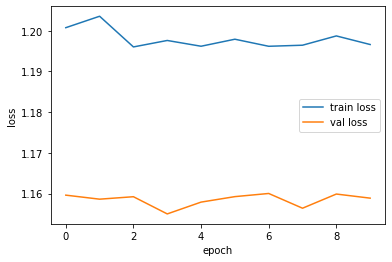

In [17]:
# check losses
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses['train_loss'])
plt.plot(losses['valid_loss'])
plt.savefig("model_epochs=10.png")
plt.legend(labels=['train loss', 'val loss']);

In [18]:
submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')